In [1]:
from LIMxCMBL.init import *
from scipy.integrate import simpson, trapezoid

In [2]:
# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

In [3]:
n_bins = 100
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_bins + 1)
chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
dchi_binned = np.mean(np.diff(chi_bin_edges))

In [4]:
import matplotlib.pyplot as plt

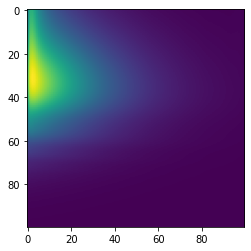

In [5]:
Ik_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_zmin_%.5f_zmax_%.5f_quad_nbins_%d.npy'%(zmin, zmax, n_bins)
I_kappa = np.load(Ik_fname)
plt.imshow(I_kappa)

In [6]:
def get_binned(base, n_external = 300):
    external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)
#     print('external chi spacing', np.mean(np.diff(external_chis)))
    
    oup = np.zeros((100, n_bins, n_bins), dtype=np.float64)
    for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
        for j, (l2, r2) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
            idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
            idx2 = np.where((external_chis > l2) & (external_chis <= r2))[0]
            oup[:,i,j] = (np.sum(base[:,
                                      idx1[0]:idx1[-1]+1,
                                      idx2[0]:idx2[-1]+1], 
                                 axis=(1, 2)) / len(idx1) / len(idx2))
    return oup

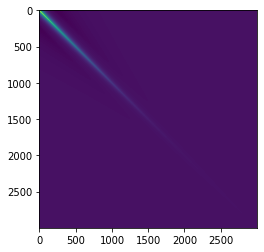

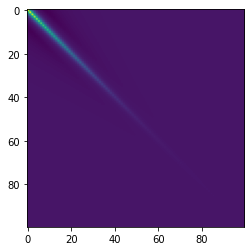

In [7]:
#get <II>

I_I_unbinned = np.load('/scratch/users/delon/LIMxCMBL/I_auto/'+
                          'I_auto_nbins_%d_zmin_%.1f_zmax_%.1f.npy'%(3000, 
                                                                     zmin, 
                                                                     zmax))

plt.imshow(I_I_unbinned[0])
plt.show()
I_I = get_binned(I_I_unbinned, n_external = 3000)
plt.imshow(I_I[0])

[]

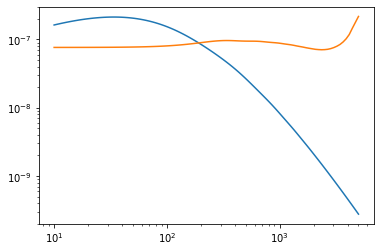

In [8]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

    
plt.plot(ells, ClKK)
plt.plot(ells, f_N0(ells))
plt.loglog()

In [9]:
from tqdm import tqdm

In [10]:
SNR2_per_mode_full = {}
SNR2_per_mode_noise_dom = {}

# full cov no filtering SNR per mode

In [11]:
from LIMxCMBL.noise import f_eIeI
cov  = np.einsum('l  , xy->lxy', (ClKK + f_N0(ells)),  Pei * np.diag(f_eIeI(chi=chi_bin_centers, dchi=dchi_binned, Lambda=0)))
cov += np.einsum('l  ,lxy->lxy', (ClKK + f_N0(ells)),  I_I)
cov += np.einsum('lx ,l y->lxy', I_kappa, I_kappa)
cov = cov.astype(np.float64)

SNR2_per_mode_full[0.0] = np.zeros_like(ells)
for ell_idx in range(len(ells)):
    L = np.linalg.cholesky(cov[ell_idx])
    y = np.linalg.solve(L, I_kappa[ell_idx])
    x = np.linalg.solve(L.T, y)
    SNR2_per_mode_full[0.0][ell_idx] = np.dot(I_kappa[ell_idx], x)

# noise dom no filtering SNR per mode

In [12]:
from LIMxCMBL.noise import f_eIeI
cov  = np.einsum('l  , xy->lxy', (ClKK + f_N0(ells)),  Pei * np.diag(f_eIeI(chi=chi_bin_centers, dchi=dchi_binned, Lambda=0)))
cov = cov.astype(np.float64)

SNR2_per_mode_noise_dom[0.0] = np.zeros_like(ells)
for ell_idx in range(len(ells)):
    L = np.linalg.cholesky(cov[ell_idx])
    y = np.linalg.solve(L, I_kappa[ell_idx])
    x = np.linalg.solve(L.T, y)
    SNR2_per_mode_noise_dom[0.0][ell_idx] = np.dot(I_kappa[ell_idx], x)

# SNR per mode with filtering

In [19]:
Lambda_idx = 24

comb_fname = '/scratch/users/delon/LIMxCMBL/I_auto/comb_'
comb_fname += 'zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_jax_quad.npy'%(zmin, zmax, 
                                                                         Lambda_idx, 
                                                                         1500,)

comb_unbinned = np.load(comb_fname)
comb = get_binned(comb_unbinned, n_external = _n_external)

In [20]:
from tqdm import trange

  0%|          | 0/100 [00:00<?, ?it/s]/share/software/user/open/py-jupyter/1.0.0_py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


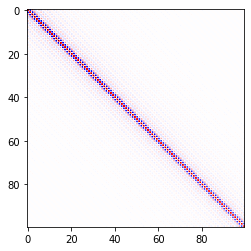

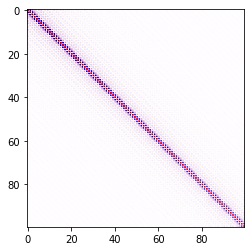

  1%|          | 1/100 [00:00<00:39,  2.49it/s]

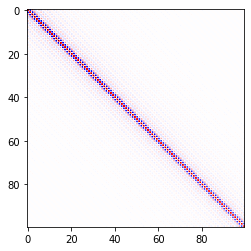

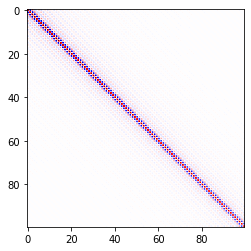

  2%|▏         | 2/100 [00:00<00:29,  3.29it/s]

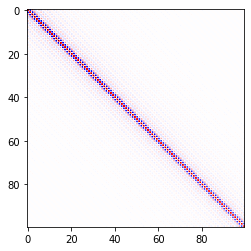

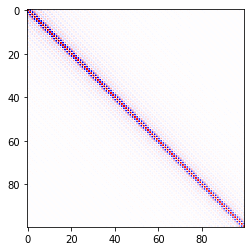

  3%|▎         | 3/100 [00:00<00:26,  3.64it/s]

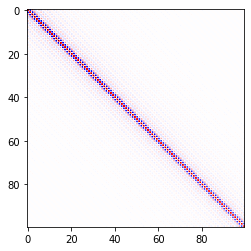

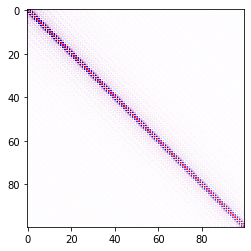

  4%|▍         | 4/100 [00:01<00:24,  3.84it/s]

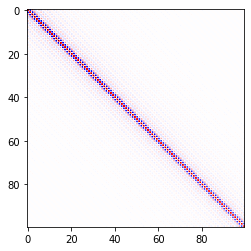

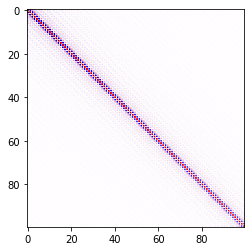

  5%|▌         | 5/100 [00:01<00:23,  4.09it/s]

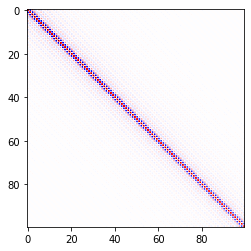

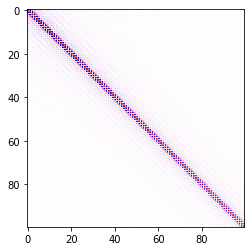

  6%|▌         | 6/100 [00:01<00:26,  3.60it/s]

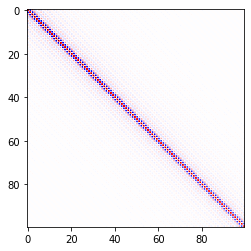

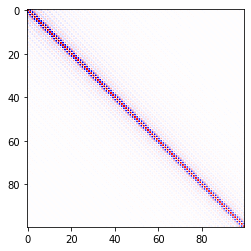

  7%|▋         | 7/100 [00:01<00:23,  4.04it/s]

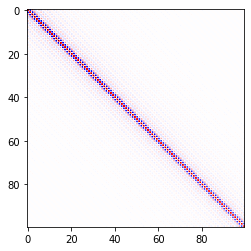

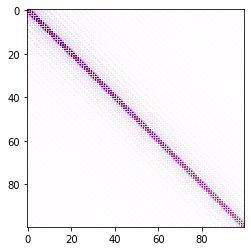

  8%|▊         | 8/100 [00:02<00:20,  4.39it/s]

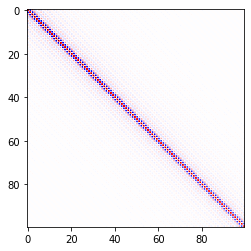

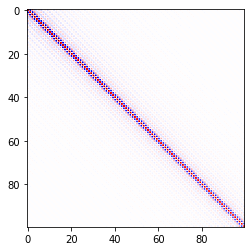

  9%|▉         | 9/100 [00:02<00:19,  4.64it/s]

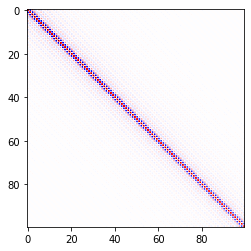

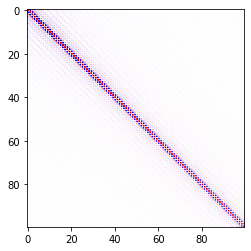

 10%|█         | 10/100 [00:02<00:18,  4.85it/s]

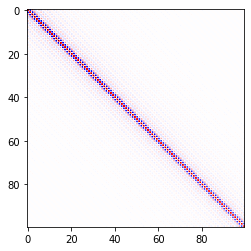

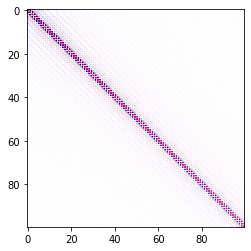

 11%|█         | 11/100 [00:02<00:20,  4.31it/s]

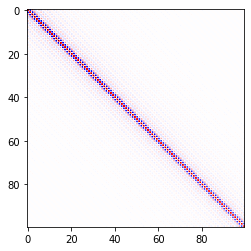

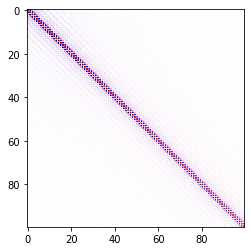

 12%|█▏        | 12/100 [00:02<00:19,  4.55it/s]

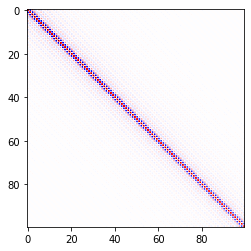

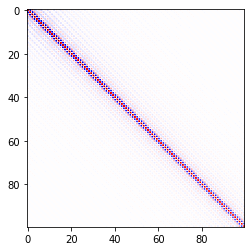

 13%|█▎        | 13/100 [00:03<00:18,  4.71it/s]

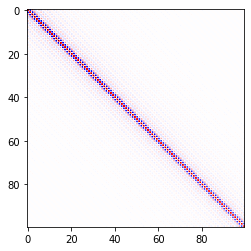

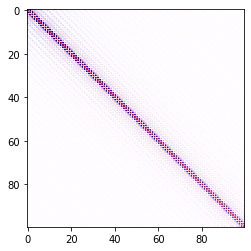

 14%|█▍        | 14/100 [00:03<00:17,  4.87it/s]

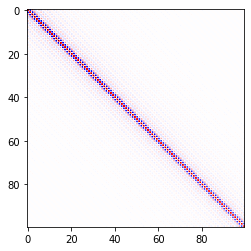

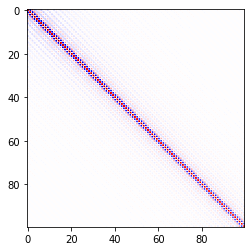

 15%|█▌        | 15/100 [00:03<00:17,  5.00it/s]

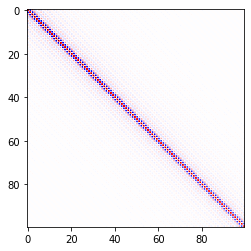

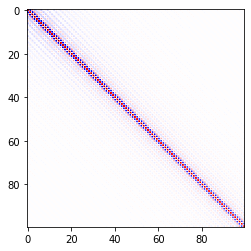

 16%|█▌        | 16/100 [00:03<00:16,  5.08it/s]

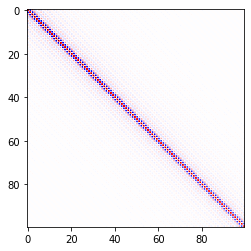

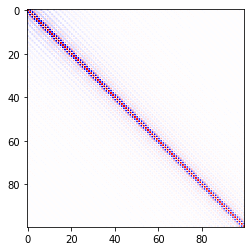

 17%|█▋        | 17/100 [00:03<00:16,  5.14it/s]

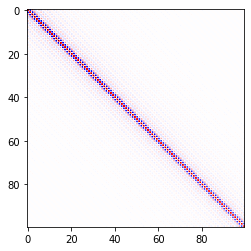

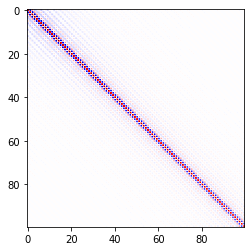

 18%|█▊        | 18/100 [00:04<00:15,  5.18it/s]

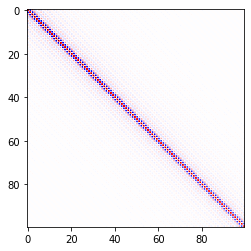

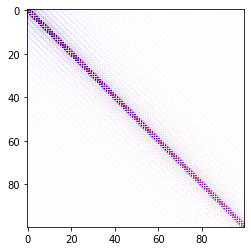

 19%|█▉        | 19/100 [00:04<00:15,  5.21it/s]

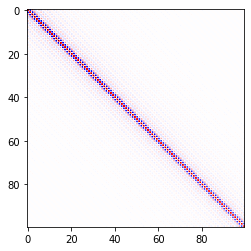

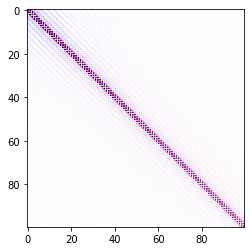

 20%|██        | 20/100 [00:04<00:15,  5.23it/s]

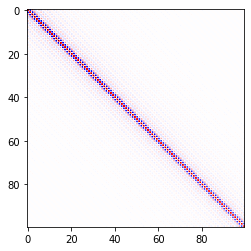

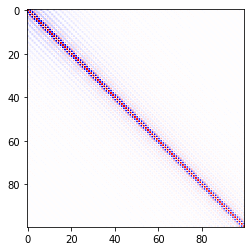

 21%|██        | 21/100 [00:04<00:15,  5.26it/s]

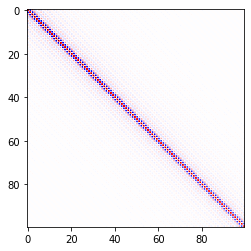

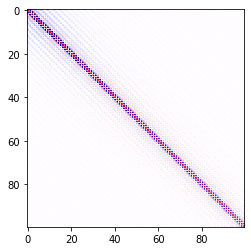

 22%|██▏       | 22/100 [00:04<00:15,  5.16it/s]

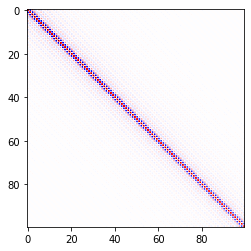

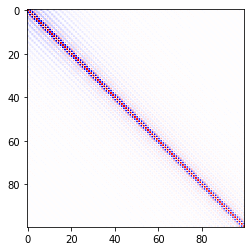

 23%|██▎       | 23/100 [00:05<00:15,  4.92it/s]

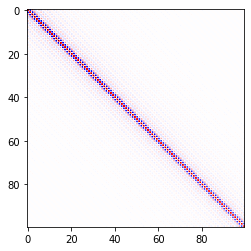

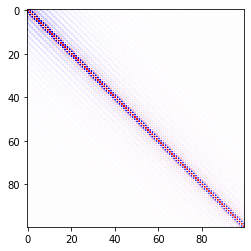

 24%|██▍       | 24/100 [00:05<00:15,  4.97it/s]

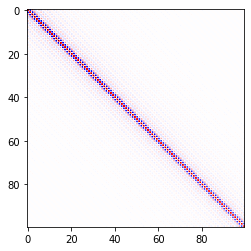

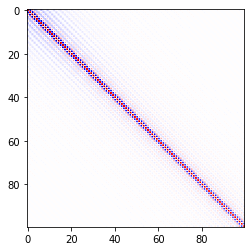

 25%|██▌       | 25/100 [00:05<00:15,  4.96it/s]

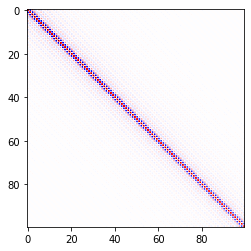

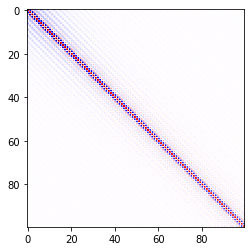

 26%|██▌       | 26/100 [00:05<00:15,  4.92it/s]

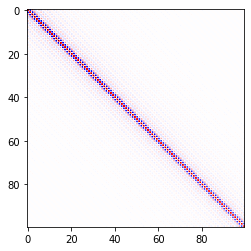

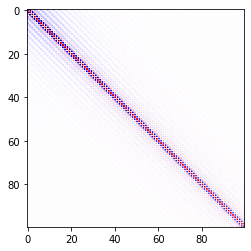

 27%|██▋       | 27/100 [00:05<00:14,  4.90it/s]

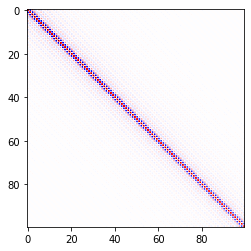

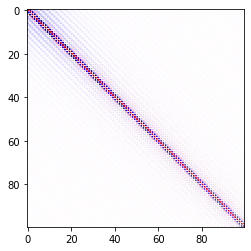

 28%|██▊       | 28/100 [00:06<00:14,  4.94it/s]

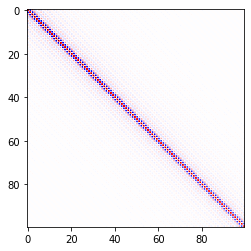

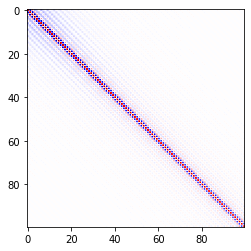

 29%|██▉       | 29/100 [00:06<00:18,  3.83it/s]

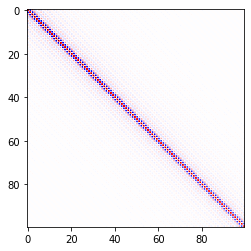

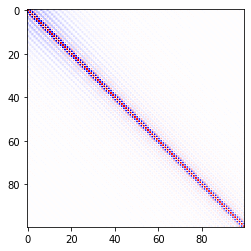

 30%|███       | 30/100 [00:06<00:18,  3.78it/s]

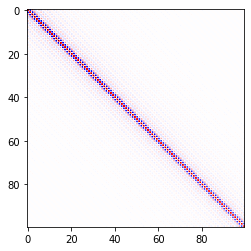

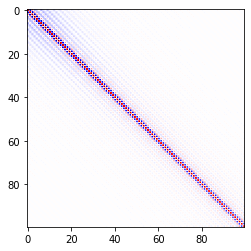

 31%|███       | 31/100 [00:06<00:16,  4.13it/s]

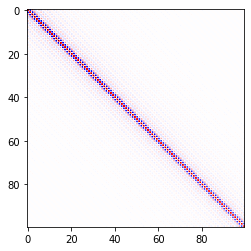

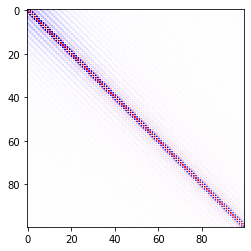

 32%|███▏      | 32/100 [00:07<00:15,  4.42it/s]

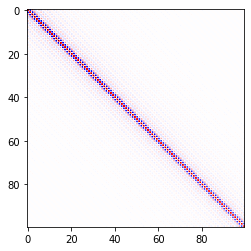

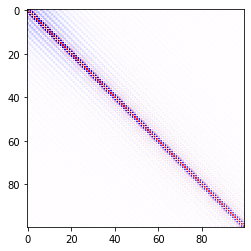

 33%|███▎      | 33/100 [00:07<00:15,  4.41it/s]

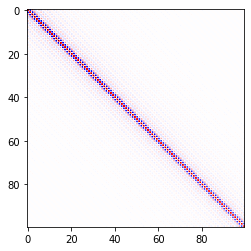

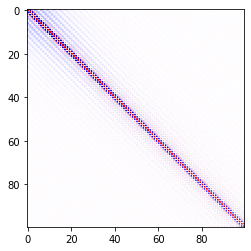

 34%|███▍      | 34/100 [00:07<00:16,  4.01it/s]

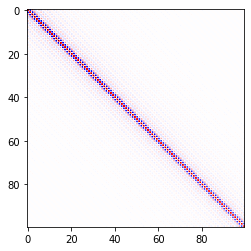

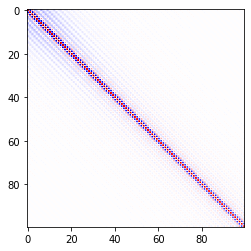

 35%|███▌      | 35/100 [00:07<00:15,  4.32it/s]

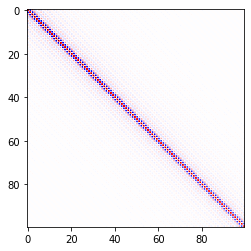

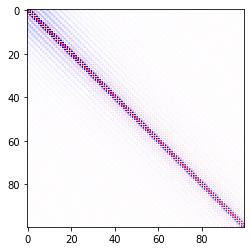

 36%|███▌      | 36/100 [00:08<00:14,  4.57it/s]

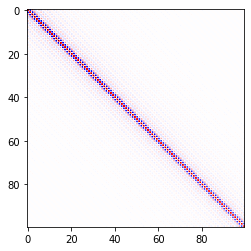

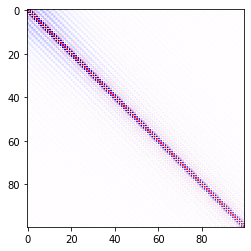

 37%|███▋      | 37/100 [00:08<00:13,  4.76it/s]

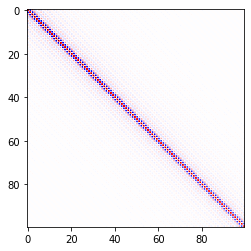

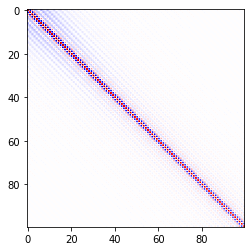

 38%|███▊      | 38/100 [00:08<00:12,  4.90it/s]

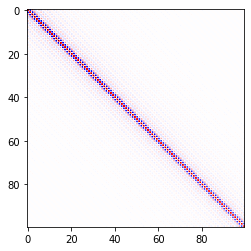

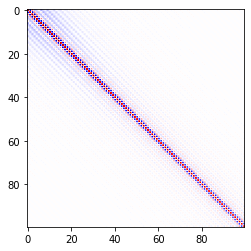

 39%|███▉      | 39/100 [00:08<00:12,  4.89it/s]

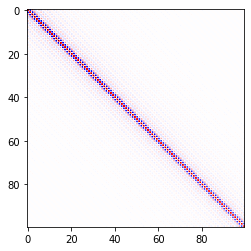

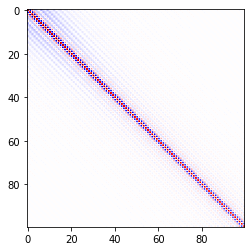

 40%|████      | 40/100 [00:08<00:12,  4.90it/s]

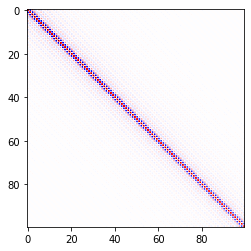

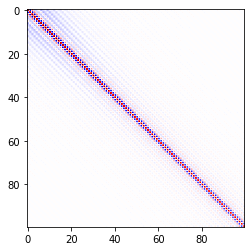

 41%|████      | 41/100 [00:08<00:11,  4.94it/s]

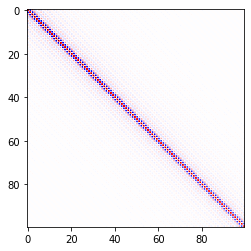

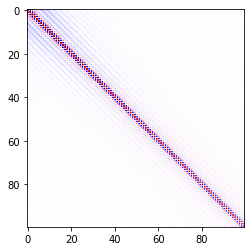

 42%|████▏     | 42/100 [00:09<00:11,  4.95it/s]

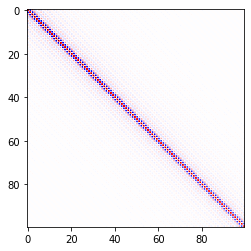

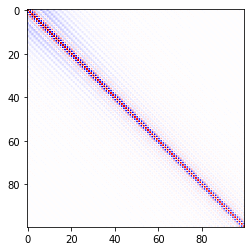

 43%|████▎     | 43/100 [00:09<00:11,  4.90it/s]

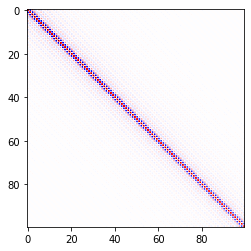

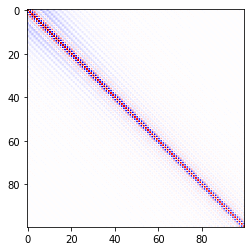

 44%|████▍     | 44/100 [00:09<00:11,  4.88it/s]

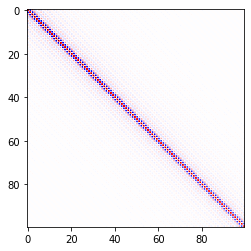

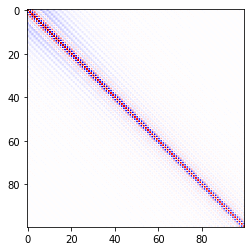

 45%|████▌     | 45/100 [00:09<00:13,  4.15it/s]

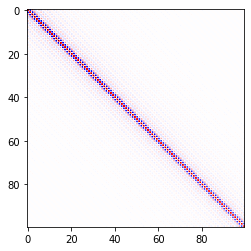

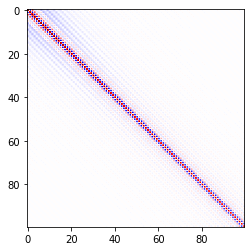

 46%|████▌     | 46/100 [00:10<00:12,  4.45it/s]

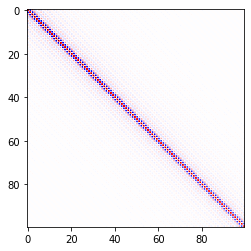

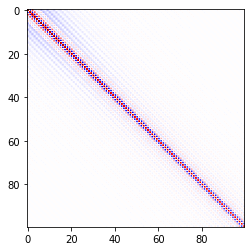

 47%|████▋     | 47/100 [00:10<00:11,  4.71it/s]

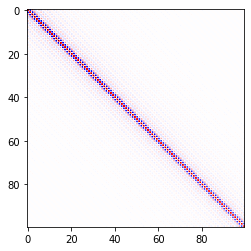

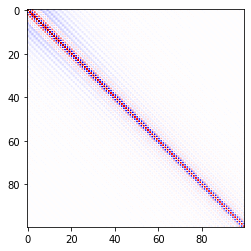

 48%|████▊     | 48/100 [00:10<00:10,  4.91it/s]

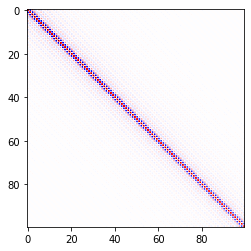

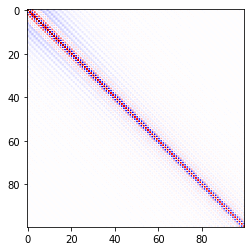

 49%|████▉     | 49/100 [00:10<00:10,  5.05it/s]

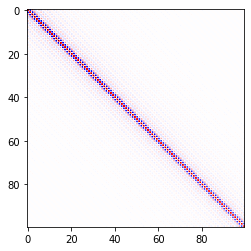

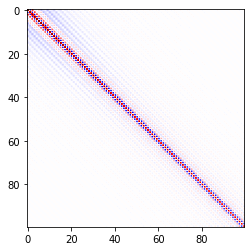

 50%|█████     | 50/100 [00:10<00:09,  5.15it/s]

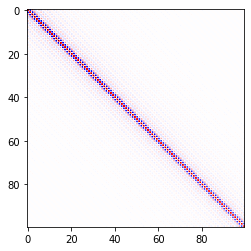

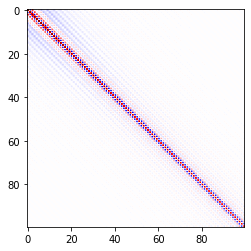

 51%|█████     | 51/100 [00:11<00:09,  5.19it/s]

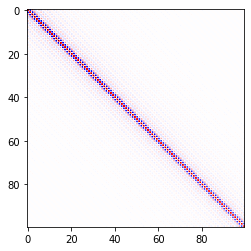

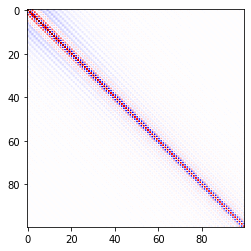

 52%|█████▏    | 52/100 [00:11<00:09,  5.16it/s]

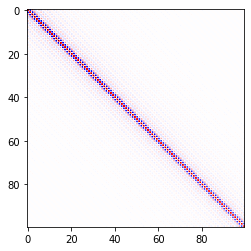

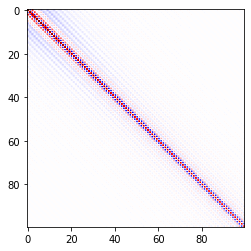

 53%|█████▎    | 53/100 [00:11<00:09,  5.16it/s]

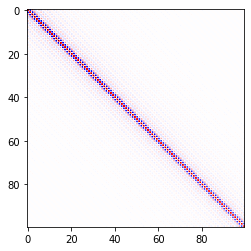

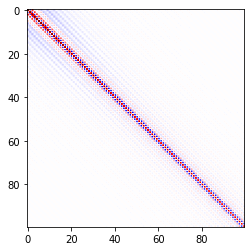

 54%|█████▍    | 54/100 [00:11<00:08,  5.23it/s]

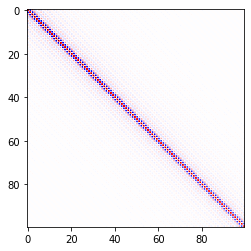

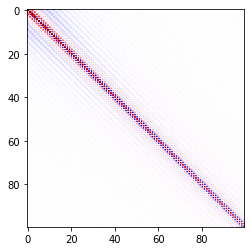

 55%|█████▌    | 55/100 [00:12<00:13,  3.33it/s]

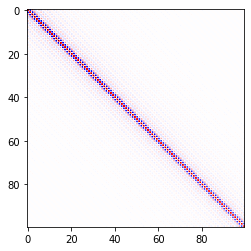

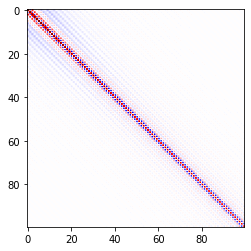

 56%|█████▌    | 56/100 [00:12<00:11,  3.71it/s]

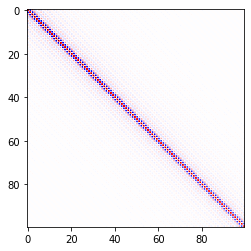

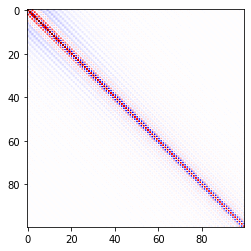

 57%|█████▋    | 57/100 [00:12<00:11,  3.60it/s]

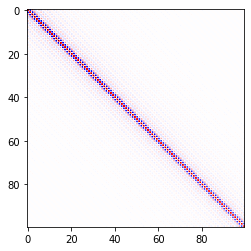

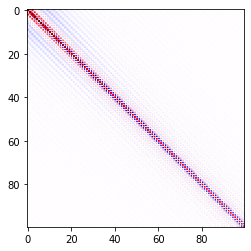

 58%|█████▊    | 58/100 [00:12<00:10,  3.93it/s]

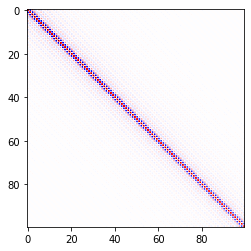

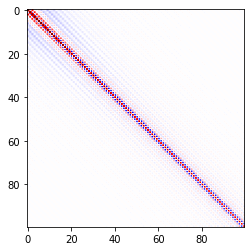

 59%|█████▉    | 59/100 [00:13<00:09,  4.19it/s]

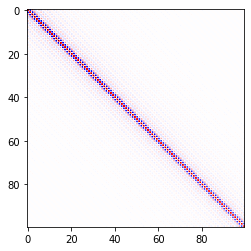

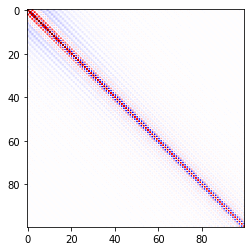

 60%|██████    | 60/100 [00:13<00:09,  4.21it/s]

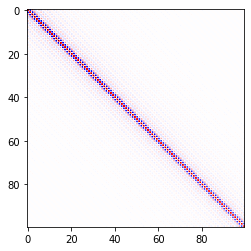

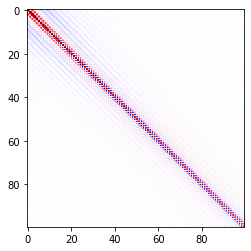

 61%|██████    | 61/100 [00:13<00:08,  4.46it/s]

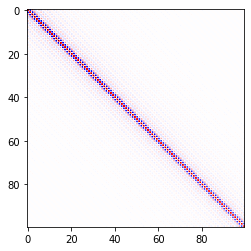

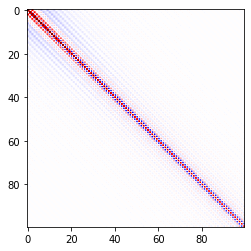

 62%|██████▏   | 62/100 [00:13<00:08,  4.66it/s]

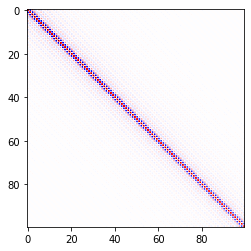

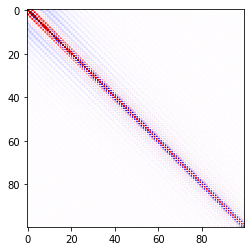

 63%|██████▎   | 63/100 [00:13<00:07,  4.78it/s]

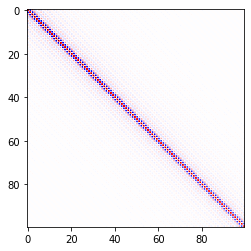

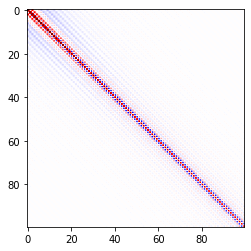

 64%|██████▍   | 64/100 [00:14<00:07,  4.86it/s]

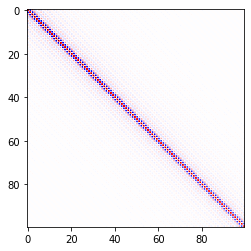

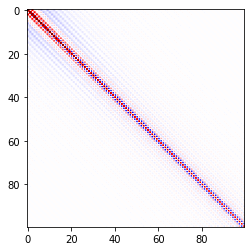

 65%|██████▌   | 65/100 [00:14<00:06,  5.01it/s]

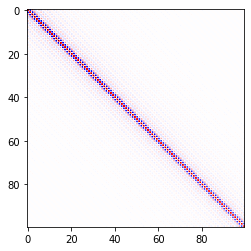

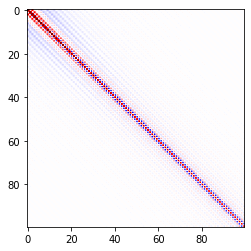

 66%|██████▌   | 66/100 [00:14<00:06,  5.09it/s]

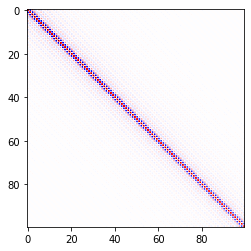

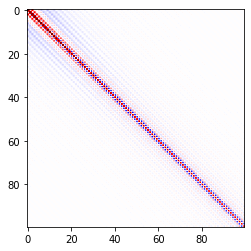

 67%|██████▋   | 67/100 [00:14<00:06,  5.16it/s]

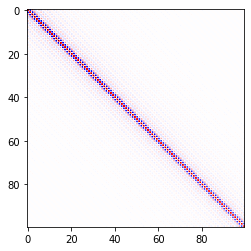

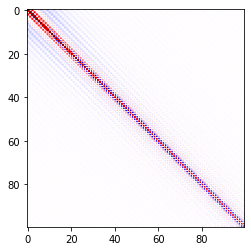

 68%|██████▊   | 68/100 [00:14<00:06,  5.18it/s]

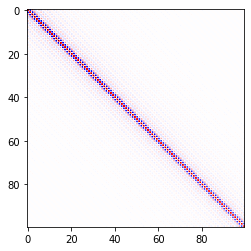

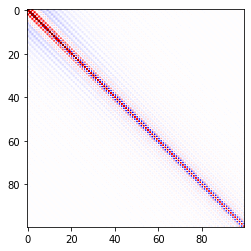

 69%|██████▉   | 69/100 [00:15<00:05,  5.21it/s]

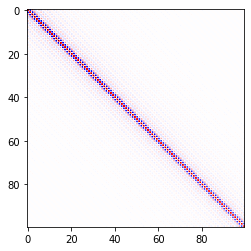

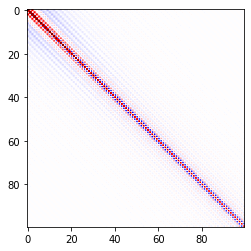

 70%|███████   | 70/100 [00:15<00:05,  5.23it/s]

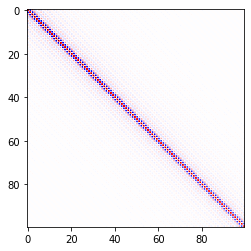

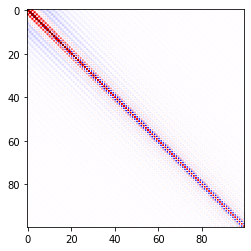

 71%|███████   | 71/100 [00:15<00:05,  5.22it/s]

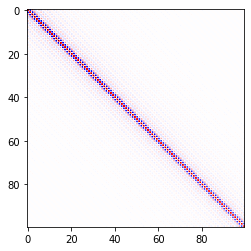

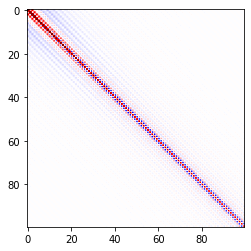

 72%|███████▏  | 72/100 [00:15<00:05,  5.17it/s]

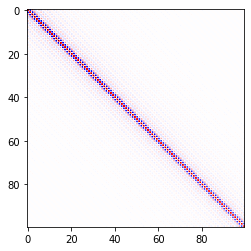

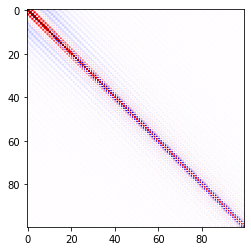

 73%|███████▎  | 73/100 [00:15<00:05,  5.20it/s]

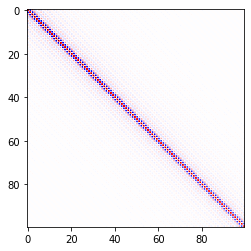

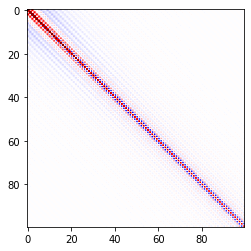

 74%|███████▍  | 74/100 [00:15<00:04,  5.21it/s]

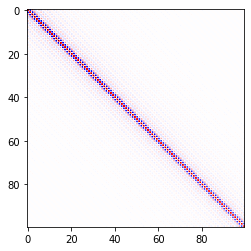

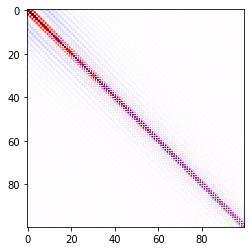

 75%|███████▌  | 75/100 [00:16<00:04,  5.12it/s]

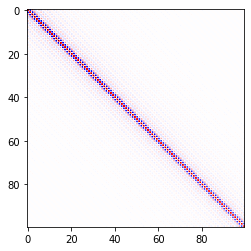

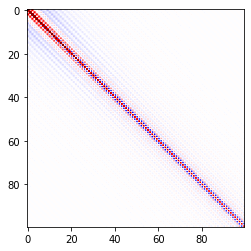

 76%|███████▌  | 76/100 [00:16<00:04,  5.09it/s]

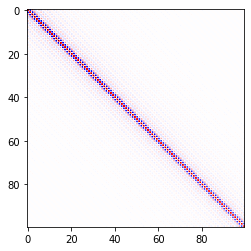

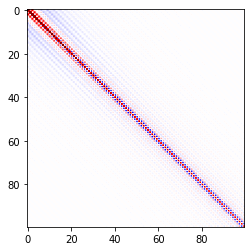

 77%|███████▋  | 77/100 [00:16<00:06,  3.66it/s]

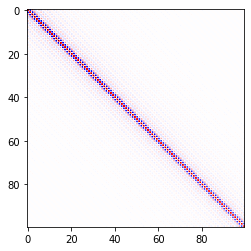

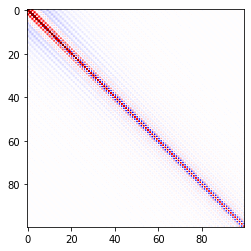

 78%|███████▊  | 78/100 [00:17<00:06,  3.41it/s]

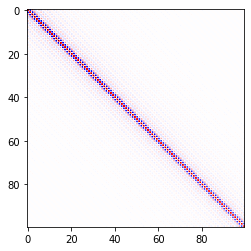

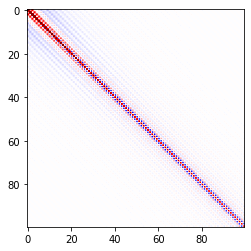

 79%|███████▉  | 79/100 [00:17<00:06,  3.49it/s]

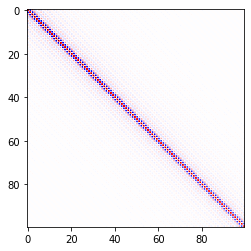

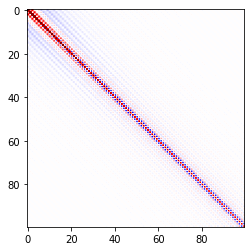

 80%|████████  | 80/100 [00:17<00:05,  3.84it/s]

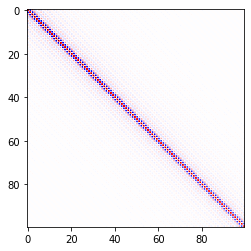

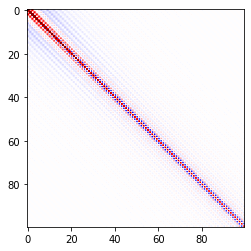

 81%|████████  | 81/100 [00:17<00:04,  4.15it/s]

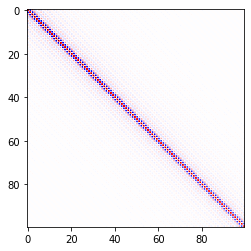

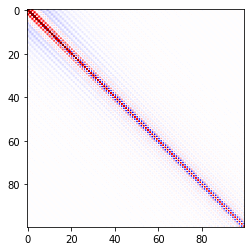

 82%|████████▏ | 82/100 [00:18<00:04,  4.40it/s]

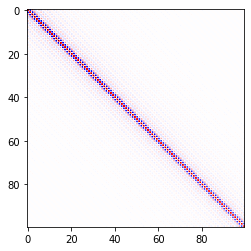

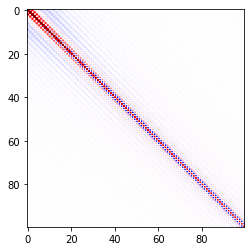

 83%|████████▎ | 83/100 [00:18<00:03,  4.62it/s]

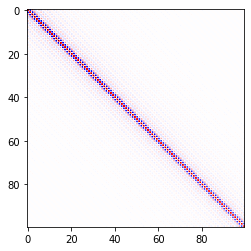

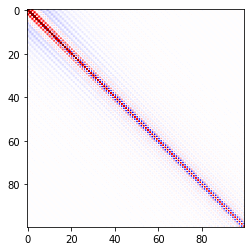

 84%|████████▍ | 84/100 [00:18<00:03,  4.78it/s]

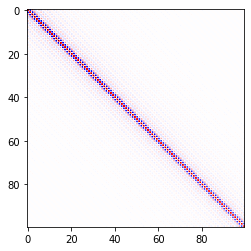

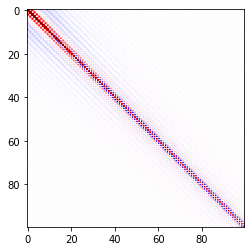

 85%|████████▌ | 85/100 [00:18<00:03,  4.89it/s]

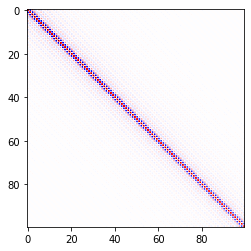

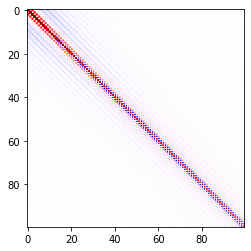

 86%|████████▌ | 86/100 [00:18<00:02,  4.97it/s]

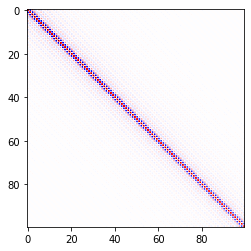

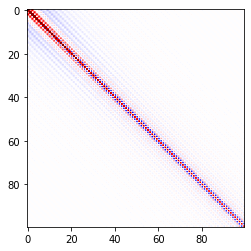

 87%|████████▋ | 87/100 [00:19<00:02,  5.03it/s]

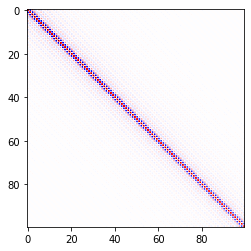

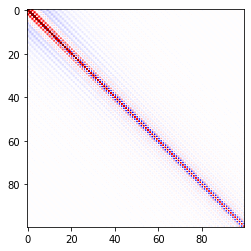

 88%|████████▊ | 88/100 [00:19<00:02,  4.89it/s]

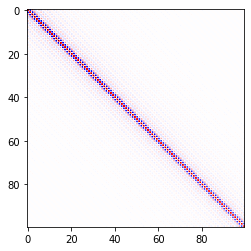

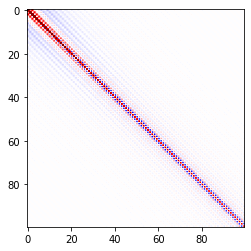

 89%|████████▉ | 89/100 [00:19<00:02,  4.29it/s]

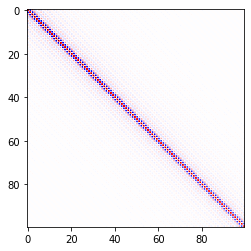

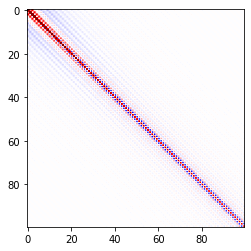

 90%|█████████ | 90/100 [00:19<00:02,  4.49it/s]

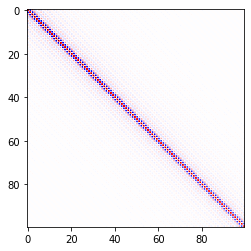

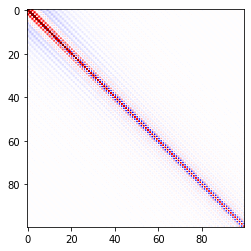

 91%|█████████ | 91/100 [00:20<00:02,  4.14it/s]

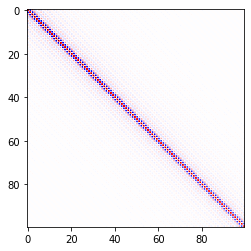

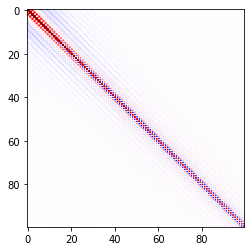

 92%|█████████▏| 92/100 [00:20<00:01,  4.36it/s]

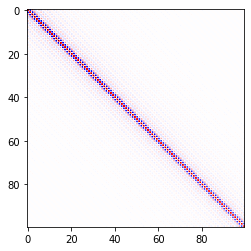

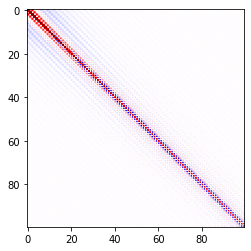

 93%|█████████▎| 93/100 [00:20<00:01,  4.56it/s]

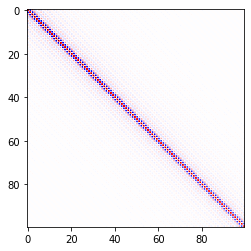

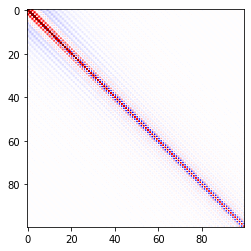

 94%|█████████▍| 94/100 [00:20<00:01,  4.65it/s]

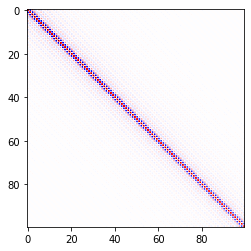

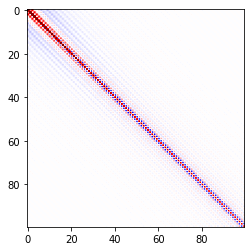

 95%|█████████▌| 95/100 [00:20<00:01,  4.73it/s]

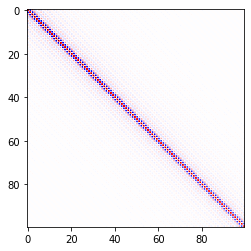

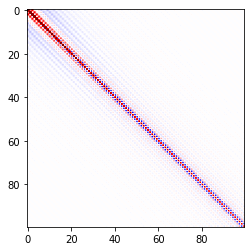

 96%|█████████▌| 96/100 [00:21<00:00,  4.70it/s]

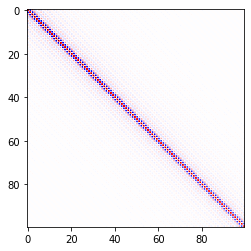

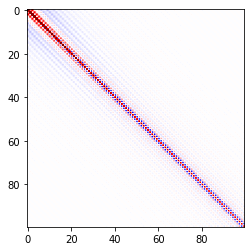

 97%|█████████▋| 97/100 [00:21<00:00,  4.84it/s]

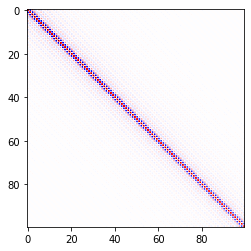

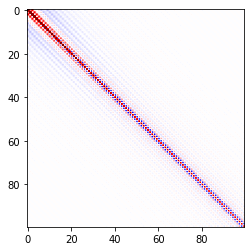

 98%|█████████▊| 98/100 [00:21<00:00,  4.95it/s]

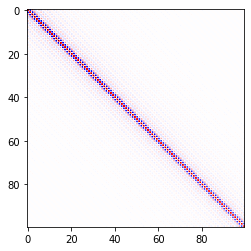

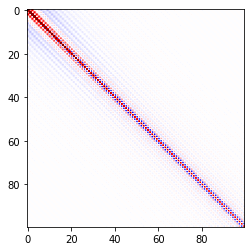

 99%|█████████▉| 99/100 [00:21<00:00,  3.68it/s]

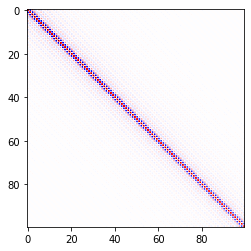

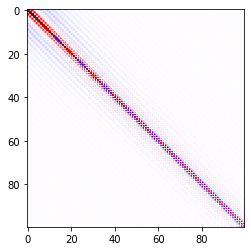

100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


In [21]:

for ell_idx in trange(len(ells)):
    Lambda = Lambdas[Lambda_idx]

    #IHi_IHi############################################
    _n_external = 1500

    ##IHi IHi
    IHiIHi = I_I + comb[ell_idx]


    ######################################################
    ILo_kappa = np.zeros((100, n_bins))

    for curr_bin in range(n_bins):
        oup_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_'
        oup_fname += 'zmin_%.5f_zmax_%.5f_idx_%d_dblquad_n_bins_%d_curr_%d.npy'%(zmin, zmax, 
                                                                                 Lambda_idx, n_bins, 
                                                                                 curr_bin)
        ILo_kappa[:,curr_bin] = np.load(oup_fname)
    IHi_kappa = I_kappa - ILo_kappa

    eHIeHI_oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/'
    eHIeHI_oup_fname += 'zmin_%.5f_zmax_%.5f_Lambda_idx_%.d_from_log2_%d_nbins_%d.npy'%(zmin, 
                                                                                       zmax, 
                                                                                       Lambda_idx, 
                                                                                       13, 
                                                                                       n_bins)
    eHIeHI_binned = np.load(eHIeHI_oup_fname)


    cov  = np.einsum('l  , xy->lxy', (ClKK + f_N0(ells)),  Pei * eHIeHI_binned)
    cov += np.einsum('lx ,l y->lxy', IHi_kappa, IHi_kappa)
    vb = np.max(np.abs(cov[0]))
    plt.imshow(cov[0],
              vmin = -vb,
              vmax = vb,
              cmap = 'seismic')
    plt.show()
    cov += np.einsum('l  ,lxy->lxy', (ClKK + f_N0(ells)),  IHiIHi)

    plt.imshow(cov[0],
              vmin = -vb,
              vmax = vb,
              cmap = 'seismic')
    plt.show()
    np.linalg.cholesky(cov[ell_idx].astype(np.float64))

In [ ]:
Lambda_idx = -1

for Lambda in tqdm(Lambdas):
    Lambda_idx += 1
    #IHi_kappa##########################################
    ILo_kappa = np.zeros((100, n_bins))

    for curr_bin in range(n_bins):
        oup_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_zmin_%.5f_zmax_%.5f_idx_%d_dblquad_n_bins_%d_curr_%d.npy'%(zmin, zmax, 
                                                                                                                            Lambda_idx, n_bins, 
                                                                                                                            curr_bin)
        ILo_kappa[:,curr_bin] = np.load(oup_fname)


    IHi_kappa = I_kappa - ILo_kappa
    ####################################################
    #IHi_IHi############################################
    ## cross terms in IHi IHi
#     cross_n_external = 300
#     cross_fname = '/scratch/users/delon/LIMxCMBL/I_auto/I_ILo_'
#     cross_fname += 'zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_quad.npy'%(zmin, zmax, 
#                                                                           Lambda_idx, 
#                                                                           cross_n_external, )

#     cross_unbinned = np.load(cross_fname)
#     assert(cross_unbinned.shape == (len(ells), cross_n_external, cross_n_external))
#     cross = get_binned(cross_unbinned, n_external = cross_n_external)
    
#     ##ILo ILo
#     ##ah I probably need to quad chib for ILoILo
#     ILoILo_n_external = 700
    
#     ILoILo_oup_fname = '/scratch/users/delon/LIMxCMBL/I_auto/ILo_ILo'
#     ILoILo_oup_fname += '_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_n_chib_%d.npy'%(zmin, 
#                                                                                      zmax, 
#                                                                                      Lambda_idx, 
#                                                                                      ILoILo_n_external, 
#                                                                                      4096)
#     ILoILo_unbinned = np.load(ILoILo_oup_fname)
#     ILoILo = get_binned(ILoILo_unbinned, n_external = ILoILo_n_external)
    
    ##IHi IHi
    IHiIHi = I_I# - cross + ILoILo
    ####################################################
    #eHI eHI############################################
    eHIeHI_oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/'
    eHIeHI_oup_fname += 'zmin_%.5f_zmax_%.5f_Lambda_idx_%.d_from_log2_%d_nbins_%d.npy'%(zmin, 
                                                                                       zmax, 
                                                                                       Lambda_idx, 
                                                                                       13, 
                                                                                       n_bins)
    eHIeHI_binned = np.load(eHIeHI_oup_fname)
    ####################################################
    #full cov###########################################
    #l -> ells
    #x -> chi
    #y -> chi'
    cov  = np.einsum('l  , xy->lxy', (ClKK + f_N0(ells)),  Pei * eHIeHI_binned)
    cov += np.einsum('l  ,lxy->lxy', (ClKK + f_N0(ells)),  IHiIHi)
    cov += np.einsum('lx ,l y->lxy', IHi_kappa, IHi_kappa)
    cov = cov.astype(np.float64)
    
    SNR2_per_mode_full[Lambda] = np.zeros_like(ells)
    for ell_idx in range(len(ells)):
        L = np.linalg.cholesky(cov[ell_idx])
        y = np.linalg.solve(L, IHi_kappa[ell_idx])
        x = np.linalg.solve(L.T, y)
        SNR2_per_mode_full[Lambda][ell_idx] = np.dot(IHi_kappa[ell_idx], x)
    ####################################################
    #noise-dom cov######################################
    cov  = np.einsum('l  , xy->lxy', (ClKK + f_N0(ells)),  Pei * eHIeHI_binned)
    cov = cov.astype(np.float64)
    SNR2_per_mode_noise_dom[Lambda] = np.zeros_like(ells)
    for ell_idx in range(len(ells)):
        L = np.linalg.cholesky(cov[ell_idx])
        y = np.linalg.solve(L, IHi_kappa[ell_idx])
        x = np.linalg.solve(L.T, y)
        SNR2_per_mode_noise_dom[Lambda][ell_idx] = np.dot(IHi_kappa[ell_idx], x)
    ####################################################

In [ ]:
Lambdas = np.array(sorted(list(SNR2_per_mode_full.keys())))

In [ ]:
rainbow_colors = plt.cm.rainbow(np.linspace(0, 1, len(SNR2_per_mode_full)))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=rainbow_colors[::-1])

In [ ]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e-1):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_full[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.title('binned full cov')
plt.ylabel(r'$\ell^2\times$(snr2 per mode)')
plt.legend(frameon=False)

In [ ]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e-1):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_noise_dom[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.title('binned noise dom')
plt.ylabel(r'$\ell^2\times$(snr2 per mode)')
plt.legend(frameon=False)

In [ ]:
#new calculation
SNR2_per_Omega_full      = np.zeros(len(Lambdas))
SNR2_per_Omega_noise_dom = np.zeros(len(Lambdas))

for Lambda_idx,Lambda in enumerate(Lambdas):
    SNR2_per_Omega_noise_dom[Lambda_idx] = trapezoid(x = np.log(ells), 
                                                     y = SNR2_per_mode_noise_dom[Lambda] 
                                                     * ells ** 2 
                                                     / 2 / np.pi)
    
    SNR2_per_Omega_full[Lambda_idx] = trapezoid(x = np.log(ells), 
                                                y = SNR2_per_mode_full[Lambda] 
                                                * ells ** 2 
                                                / 2 / np.pi)

In [ ]:
plt.figure(figsize = (5,5) ,dpi = 300, facecolor = 'w')





plt.plot(Lambdas, (SNR2_per_Omega_noise_dom * Omega_field), 
         'r',
        label='binned noise dom')

plt.plot(Lambdas, (SNR2_per_Omega_full * Omega_field), 
         'k',
        label='binned full cov (NOT YET)')



plt.xscale('symlog', linthresh = 1e-5)
plt.yscale('symlog', linthresh = 1e-1)

fundamental = 2*np.pi/(chimax - chimin)
plt.xlim(0, 1e-1)
plt.ylim(0, 1)


plt.xlabel(r'$\Lambda$')
plt.ylabel(r'${\sf SNR}^2$')
plt.title('CCAT-Prime')
plt.legend(frameon=False)